In [2]:
# from BZ import *
import xarray as xr
import rioxarray as xrr
import contextily as cx
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io import img_tiles as cimgt
from matplotlib.patches import Patch

from shapely.geometry import box

from shared import *
from make_slr_cari import main

%matplotlib inline
%pdb off

print (os.getenv('CONDA_PROMPT_MODIFIER'), datetime.now())
# Rule: SetNull(CoNED < MLLW | (CoNED > ZT & ElNino > ZT)

Automatic pdb calling has been turned OFF
(SL)  2024-06-20 08:45:38.738399


## Setup 

In [3]:
region  = 'Central' 
use_s2  = False
path_wd = Path(os.getenv('dataroot')) / 'Sea_Level' / 'SFEI'
print ('Region:', region)

Region: Central


## Constants 
- Shouldn't have to change below here (in setup)

In [4]:
BObj = CARIRegion(region, path_wd, use_s2)
gdf_beach_coned = BObj.get_cari('beach')
gdf_beach_wgs = gdf_beach_coned.to_crs(4326)

s2_ext = '_s2' if use_s2 else ''
path_log = BObj.path_wd / f'log_{BObj.region}_pct{s2_ext}.txt'

In [5]:
basemap_d = cimgt.GoogleTiles(url='https://server.arcgisonline.com/ArcGIS/rest/services/Elevation/World_Hillshade_Dark/MapServer/tile/{z}/{y}/{x}.jpg')
basemap   = cimgt.GoogleTiles(url='https://server.arcgisonline.com/arcgis/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}.jpg')

cxbasemap   = cx.providers.Esri.WorldImagery
cxbasemap_d = cx.providers.CartoDB.DarkMatter
cxbasemap_t = cx.providers.USGS.USTopo

projp     = ccrs.PlateCarree()

dct_proju = {'Central': ccrs.UTM(10), 'North': ccrs.UTM(10), 'South': ccrs.UTM(11)}
proju     = dct_proju[region]

TFS = 20 # title
XFS = YFS = 16 # x/y axis
GFS = 14 # deg marks
CFS = 18 # colorbar labels
pt_parms = dict(verticalalignment='top', fontsize=20, color='w',
                bbox=dict(boxstyle='square,pad=0.05', facecolor='black'))

## setup plot parms and patch label outines
sty_cari   = dict(facecolor='none', edgecolor='deeppink') 
sty_coned  = dict(facecolor='none', edgecolor='red', linestyle='--')

rect_coned = Patch(label='CoNED Tile', **sty_coned)
rect_beach = Patch(label='CARI Beach', **sty_cari)

point      = plt.Line2D([0], [0], marker='o', color='k', label='Beach', linestyle='none')
point_lost = plt.Line2D([0], [0], marker='o', color='k', label='Lost Beach', linestyle='none')

In [6]:
def buffer_poly(gser, buffx, buffy=None):
    buffy = buffx if buffy is None else buffy
    
    w, s, e, n = gser.total_bounds
    return w-buffx, s-buffy, e+buffx, n+buffy
    

# Initial Diagnostics

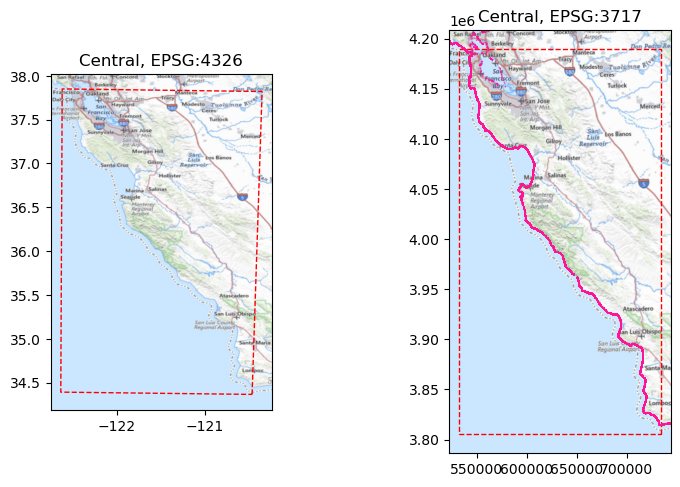

In [32]:
# regional coned_bounds and cari
gdf_bounds_coned = gpd.GeoSeries(box(BObj.Wr, BObj.Sr, BObj.Er, BObj.Nr), crs=BObj.epsg)
gdf_bounds_wgs = gdf_bounds_coned.to_crs(4326)

fig, axes = plt.subplots(figsize=(8, 8), ncols=2)

for i, (gdf, ax) in enumerate(zip([gdf_bounds_wgs, gdf_bounds_coned], axes)):
    ax = gdf.plot(ax=ax, **sty_coned)
    cx.add_basemap(ax=ax, crs=gdf.crs, source=cxbasemap_t, attribution=False)#, zoom=16)
    ax.set_title(f'{region}, {gdf.crs}')
    if i == 1:
        gdf_beach_coned.plot(ax=ax, **sty_cari)
        
fig.subplots_adjust(wspace=0.8)

# Check Results

## Single Test Run

### Make Beaches

In [11]:
scen_test0 = 'med_rsl2050'
scen_test = scen_test0.replace('_rsl', '')

In [13]:
da_dem_test, da_mllw0_test, da_mllw_slr_test, df_slr_test, poly_test = main(region, 'beach', scen_test0, use_s2=use_s2, test=True)

INFO:   main:118    [Jun 05, 16:16:54] 137 beach polygons within CentCA_south_Topobathy_CoNED_1m_C4

CRITICAL:   main:149    [Jun 05, 16:17:24] CentCA_south_Topobathy_CoNED_1m_C4, polyix=5305 cari id=542398:
CRITICAL:   compare_elevations_poly:71     [Jun 05, 16:17:29] 	99.749% ABOVE MLLW today; 93.039 in med_rsl2050. 	Lost: 6.710% 


In [14]:
# check this matches the log output in previous cell
tile_stem = 'CentCA_south_Topobathy_CoNED_1m_C4' # copied from the log output above
df_slr_test['lost_beach'] = df_slr_test['MLLW'] - df_slr_test[f'{scen_test0}_MLLW'] # if this is 1, then we lost it (1-0)
poly_ix_test = df_slr_test['poly_ix'].unique().item()
print (f'Poly ix={poly_ix_test} Lost: {100*df_slr_test["lost_beach"].mean():.2f}%')

Poly ix=5305 Lost: 6.71%


### Sanity Check to recreate logic with one polygon

In [45]:
# get just the dem values in the polygon itself for the stats
da_dem_test_poly = da_dem_test.rio.clip([poly_test], da_dem_test.rio.crs, all_touched=True)
da_dem_test_poly = da_dem_test_poly.where(da_dem_test_poly>-3e3)
da_dem_test_poly.rio.write_nodata(da_dem_test_poly.rio.nodata, encoded=True, inplace=True);

In [46]:
da_dem_mllw0i_test    = (da_dem_test_poly>da_mllw0_test).astype(int)
da_dem_mllw_slri_test = (da_dem_test_poly>da_mllw_slr_test).astype(int)

In [47]:
da_dem_mllw0i_test    = da_dem_mllw0i_test.where(~da_dem_test_poly.isnull())
da_dem_mllw_slri_test = da_dem_mllw_slri_test.where(~da_dem_test_poly.isnull())

pct0  = 100*(da_dem_mllw0i_test.mean())
pct1  = 100*(da_dem_mllw_slri_test.mean())
pct_lost = pct0-pct1

## correctly matches both above and the log file
msg =  (f'{tile_stem}, polyID: {poly_ix_test}: {pct0.item():.3f} {pct1.item():.3f}. Lost: {pct_lost.item():.3f}%')
print (msg)

CentCA_south_Topobathy_CoNED_1m_C4, polyID: 5305: 99.749 93.039. Lost: 6.710%


In [48]:
da_lost = ((da_dem_test_poly>da_mllw0_test) & (da_dem_test_poly < da_mllw_slr_test)).astype(int)
n_non = da_dem_test_poly.size - (da_dem_test_poly.isnull().sum())

da_lost = da_lost.where(da_lost>0)
print (f'Lost: {100*da_lost.sum()/n_non:.3f}%') # good, matches 

Lost: 6.710%


### Plot Everything

In [ ]:
# get bounds and buffer for plot extent
buff     = 2.5e2 
wd, sd, ed, nd = da_dem_test.rio.bounds()

da_mask0 = da_dem_test > da_mllw0_test # original beaches
da_mask1 = da_dem_test > da_mllw_slr_test # new beaches
da_resid = da_mask0.astype(int) - da_mask1.astype(int)
da_resid = xr.where(da_resid>0, -1, np.nan) # show the new underwater locations

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(24, 24), subplot_kw={'projection':proju})

for ax in axes.ravel():
    ax.set_extent([wd-buff,ed+buff,sd-buff,nd+buff], crs=ccrs.UTM(10))
    # cx.add_basemap(ax=ax, crs=da_dem2.rio.crs, source=cx.providers.CartoDB.DarkMatter, attribution=False, zoom=13)
    cx.add_basemap(ax=ax, crs=da_dem_test.rio.crs, source=cxbasemap_t, attribution=False, zoom=14)
    ax.add_geometries([poly_test], zorder=11, crs=proju, linewidth=1.5, **sty_cari)

sty = dict(shading='nearest', transform=ccrs.UTM(10), cmap='binary', norm=mpl.colors.Normalize(0, 1.5))
## dem
im = axes[0, 0].pcolormesh(da_dem_test.x, da_dem_test.y, da_dem_test, alpha=0.5, **sty)
bbPlot.cartopy_cbar(im, f'Elevation (m)')
axes[0,0].set_title('CoNED DEM', fontsize=TFS)

## residual
sty['cmap'] = 'binary_r'
im = axes[1, 0].pcolormesh(da_resid.x, da_resid.y, da_resid, **sty)
cbar = bbPlot.cartopy_cbar(im, f'Elevation (m)')
cbar.ax.set_visible(False)
axes[1,0].set_title('Lost Beaches', fontsize=TFS)

## MLLW
sty['cmap'] = 'Blues_r'
axes[0,2].set_title('MLLW Mask', fontsize=TFS)
im = axes[0, 1].pcolormesh(da_mllw0_test.x, da_mllw0_test.y, da_mllw0_test, **sty)
                           
bbPlot.cartopy_cbar(im, f'MLLW (m)')
axes[0,1].set_title('MLLW No SLR', fontsize=TFS)

im = axes[1, 1].pcolormesh(da_mllw_slr_test.x, da_mllw_slr_test.y, da_mllw_slr_test, **sty)
bbPlot.cartopy_cbar(im, f'MLLW (m)')
axes[1,1].set_title('MLLW SLR', fontsize=TFS)

## Masks
sty['cmap'] = 'binary'
sty['norm'] = mpl.colors.BoundaryNorm([0, 1, 2], 256)
im = axes[0, 2].pcolormesh(da_mask0.x, da_mask0.y, da_mask0,  **sty)
cbar = bbPlot.cartopy_cbar(im)
cbar.ax.tick_params(length=0)
cbar.set_ticks([0.65, 1.6])
cbar.set_ticklabels(['Not Beach', 'Beach'], rotation=270, fontsize=CFS)
axes[0,2].set_title('At MLLW', fontsize=TFS)

im   = axes[1, 2].pcolormesh(da_mask1.x, da_mask1.y, da_mask1, **sty)
cbar = bbPlot.cartopy_cbar(im)
cbar.set_ticks([0.65, 1.6])
cbar.ax.tick_params(length=0)
cbar.set_ticklabels(['Not Beach', 'Beach'], rotation=270, fontsize=CFS)
axes[1,2].set_title(f'At {scen_test0}', fontsize=TFS)

fig.subplots_adjust(hspace=-0.35)

### Check Against Final Results 
- double check the one just created against the one in the files

In [ ]:
# get the big result; takes a long time
gdf_test = gpd.read_file(BObj.path_res / f'{region}_beaches{s2_ext}.GeoJSON')
df_test = pd.DataFrame(gdf_test.drop(columns='geometry'))
print (f'Got {region} beaches.')

In [ ]:
df_poly_test = df_test.groupby('poly_ix').get_group(poly_ix_test)
tile_ix_test = df_poly_test.tile.unique().item()
pct_lost_test = 100 * df_poly_test[scen_test].mean()
# check it from the full merged file
print (f'Poly ix={poly_ix_test} lost: {pct_lost_test:.2f}%') # should match above

gdf_tile_test = gpd.read_file(BObj.path_ca_dems / f'{tile_ix_test}_beach{s2_ext}.GeoJSON')
gdf_poly_test = gdf_tile_test.groupby('poly_ix').get_group(poly_ix_test).copy()

# if this is 1, then we lost it (1-0)
gdf_poly_test['lost'] = gdf_poly_test['MLLW'] - gdf_poly_test[scen_test0]

# check it from the tiles file
pct_lost_test = 100 * gdf_poly_test['lost'].mean()
print (f'Poly ix={poly_ix_test} lost: {pct_lost_test:.2f}%') # should match above

In [ ]:
## percentages of beaches lost in each DEM tile within this region
df_pct_tiles = 100 * df_test.groupby('tile')[scen_test].mean()
df_pct_tiles.sort_values(ascending=False, inplace=True)
print (df_pct_tiles)

print (f'\nOverall, {region} lost {100*df_test[scen_test].mean():.2f}%')
# print (f'{region} overall lost about {df_pct_tiles.mean():.2f}%') # will be slightly different than above cuz of averaging

## Single DEM Tile

In [108]:
tile_beach_ix1 = 11 # pick a dem tile of beaches to look at
poly_ix1 = 5311

In [101]:
path_beach_tiles = sorted(list(BObj.path_ca_dems.glob(f'*beach{s2_ext}.GeoJSON')))
path_beach_tile = path_beach_tiles[tile_beach_ix1]
print (f'Tile: {path_beach_tile}')

Tile: /scratch/tws_grace/data/Sea_Level/SFEI/dems/CA_Central_CoNED_DEM_2017_8657/CentCA_south_Topobathy_CoNED_1m_B2_beach.GeoJSON


In [107]:
# 1 means its beach, 0 means its underwater
gdf_btile1 = gpd.read_file(path_beach_tile)
gdf_btile1['lost_beach'] = gdf_btile1['MLLW'] - gdf_btile1[scen] # if this is 1, then we lost it (1-0)

print (gdf_btile1.head())
print (f'{len(gdf_btile1.poly_ix.unique())} unique polygons in tile')

   MLLW  med_rsl2050  poly_ix                        geometry  lost_beach
0   1.0          0.0     5311  POINT (626770.500 3991675.500)         1.0
1   1.0          0.0     5311  POINT (626771.500 3991675.500)         1.0
2   1.0          0.0     5311  POINT (626772.500 3991675.500)         1.0
3   1.0          0.0     5311  POINT (626773.500 3991675.500)         1.0
4   1.0          0.0     5311  POINT (626774.500 3991675.500)         1.0
9 unique polygons in tile


### Plot the whole dem tile

In [143]:
wt, st, et, nt = gdf_btile1.total_bounds
gser_coned_bounds = gpd.GeoSeries(box(wt, st, et, nt), crs=gdf_btile1.crs)
gdf_btile_cari = gdf_beach_coned.cx[wt:et, st:nt]

gdf_btile_plot = gdf_btile1.where(gdf_btile1 != 0, np.nan) # just show blacks where beach exists and is lost

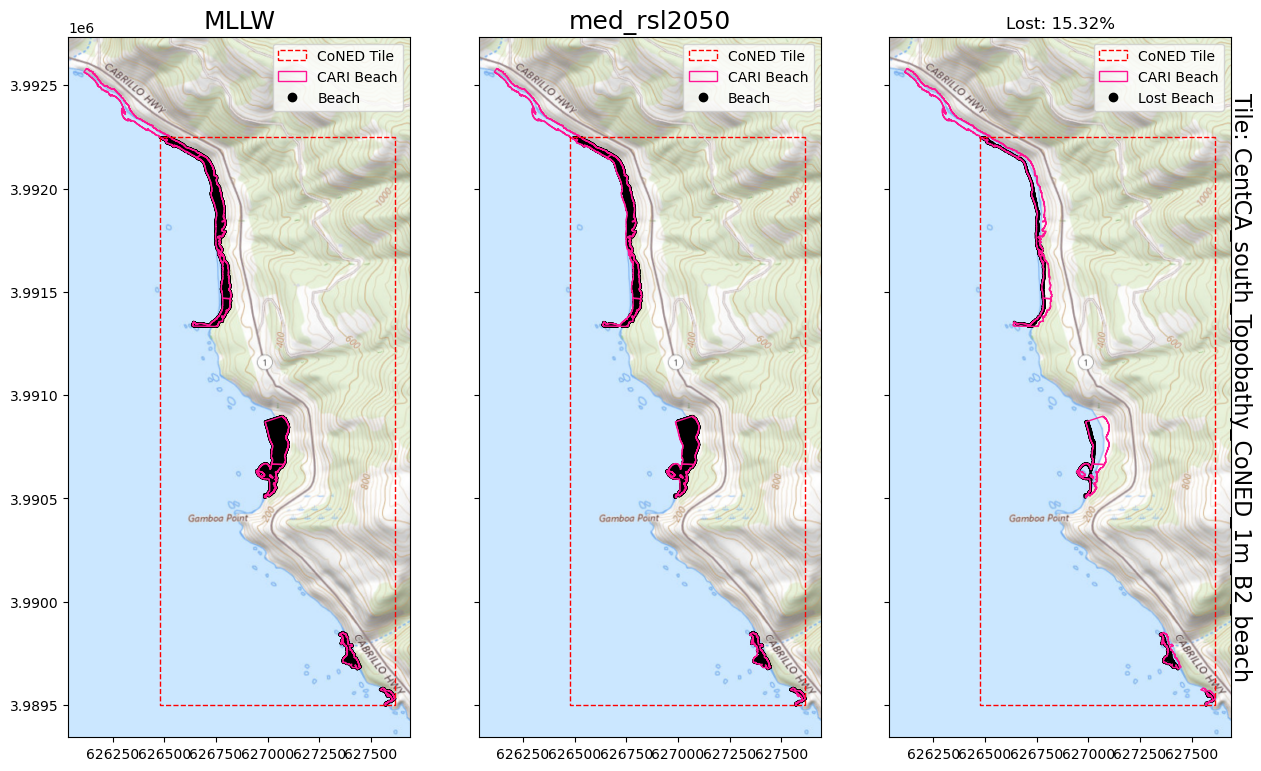

In [202]:
fig, axes = plt.subplots(figsize=(15, 12), ncols=3, sharey=True)
for ax, col in zip(axes, f'MLLW {scen} lost_beach'.split()):
    gdf_btile_plot.plot(ax=ax, column=col, cmap='binary_r', markersize=1, legend=False, categorical=True)
    gdf_btile_cari.plot(ax=ax, **sty_cari)
    # add the coned bounds too
    gser_coned_bounds.plot(ax=ax, **sty_coned)
    cx.add_basemap(ax=ax, crs=gser_coned_bounds.crs, source=cxbasemap_t, attribution=False)#, zoom=16)
    ax.set_title(col, fontsize=TFS-2)

    pt = point_lost if col == 'lost_beach' else point
    ax.legend(handles=[rect_coned, rect_beach, pt], loc='upper right')
    
pct_lost = 100*(gdf_btile1['lost_beach'].mean())
ax.set_title(f'Lost: {pct_lost:.2f}%')
ax.yaxis.set_label_position("right")
ax.set_ylabel(f'Tile: {path_beach_tile.stem}', rotation=270, labelpad=15, fontsize=YFS);

### Plot all polygons in dem tile

In [111]:
gdf_btile1_poly1 = gdf_btile1[gdf_btile1['poly_ix'] == poly_ix1]

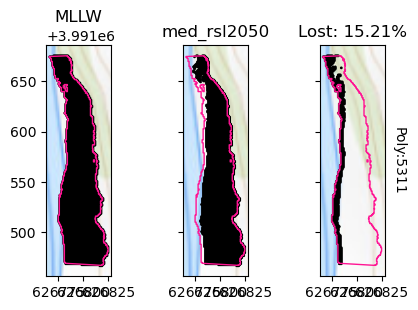

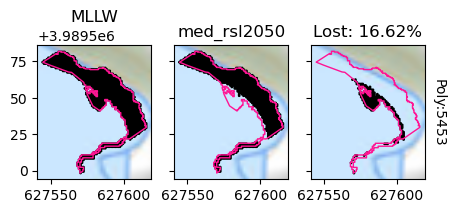

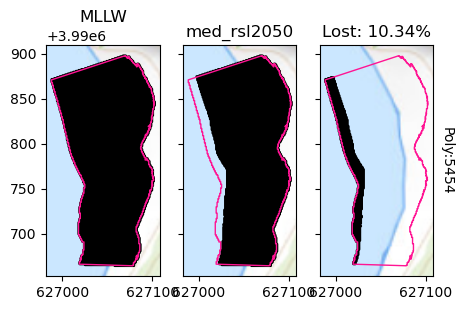

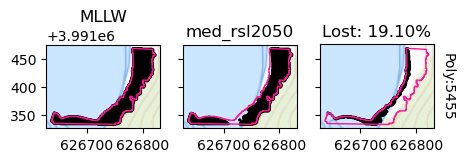

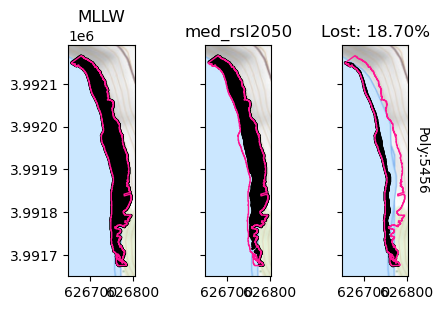

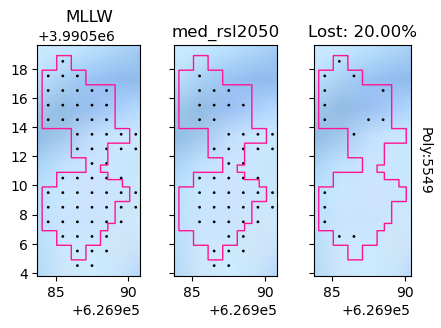

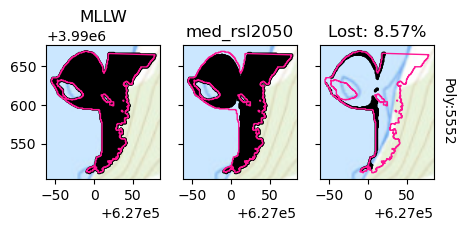

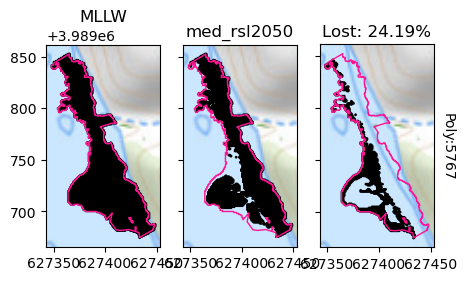

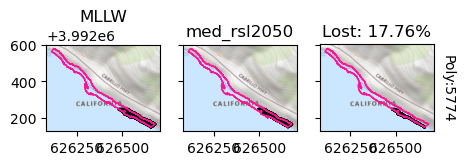

In [245]:
for poly_ix, gdfi in gdf_btile1.groupby('poly_ix'):
    pct_lost = 100*gdfi['lost_beach'].mean() # before nans
    gdfi = gdfi.where(gdfi != 0, np.nan)
    fig, axes = plt.subplots(figsize=(5, 3), ncols=3, sharey=True)
    for ax, col in zip(axes, f'MLLW {scen} lost_beach'.split()):
        gdfi.plot(ax=ax, column=col, cmap='binary_r', markersize=1)
        gdf_beach_coned.loc[[poly_ix]].plot(ax=ax, **sty_cari)
        cx.add_basemap(ax=ax, crs=gdf_beach_coned.crs, source=cxbasemap_t, attribution=False, zoom=16)
        ax.set_title(col)
    ax.yaxis.set_label_position('right')
    ax.set_ylabel(f'Poly:{poly_ix}', rotation=270, labelpad=15)
    ax.set_title(f'Lost: {pct_lost:.2f}%')

## Specific Polygon
- Plot specific polygon from the full file

### Plot the Overall Percent Lost 

In [163]:
poly_ixs  = [4, 5311]
scenp0 = 'med_rsl2050'
scenp = scenp0.replace('_rsl', '')
gdf_lost = gpd.read_file(BObj.path_res / f'beach_loss_{scenp}.GeoJSON')


poly_ix    med2050  CARI_id  \
0        0  11.151218       12   
1        1   5.788231       13   
2        2   0.000000      476   
3        3   0.000000      477   
4        4  25.095057      478   

                                            geometry  
0  POLYGON ((202772.510 -493273.469, 202769.710 -...  
1  POLYGON ((202520.731 -492772.764, 202521.231 -...  
2  POLYGON ((-278796.597 57720.716, -278809.400 5...  
3  POLYGON ((-279197.896 57989.678, -279207.293 5...  
4  POLYGON ((-282344.134 59846.100, -282341.743 5...

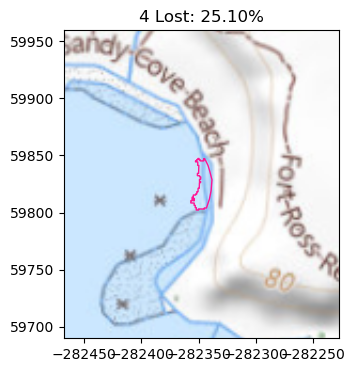

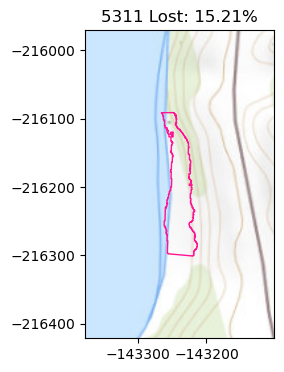

In [171]:
gdf_lost_plot = gdf_lost[gdf_lost.poly_ix.isin(poly_ixs)]
for ix in gdf_lost_plot.index:
    gdfi = gdf_lost_plot.loc[[ix]]
    poly_ixi = gdfi.poly_ix.item()
    pct_lost = gdfi[scenp].item()
    fig, axes = plt.subplots(figsize=(4, 4))
    gdfi.plot(ax=axes, **sty_cari)
    gdfi.buffer(100).plot(ax=axes, alpha=0) # make the plot bigger
    cx.add_basemap(ax=axes, crs=gdfi.crs, source=cxbasemap_t, attribution=False, zoom=16)
    axes.set_title(f'{poly_ixi} Lost: {pct_lost:.2f}%')

### Find the tiles to plot the Points

In [184]:
# search for the poly ix in the tiles to  plot the actual points
path_dems_all = BObj.path_wd / 'dems' / 'all'
assert path_dems_all.exists(), 'symlink all the files in "dem" to "dem/all"'
paths_search = list(path_dems_all.glob(f'*_beach{s2_ext}.GeoJSON'))
lst_res = []
for i, path in enumerate(paths_search):
    print (f'Searching {i} of {len(paths_search)}...') if i%10 == 0 else ''
    gdfi = gpd.read_file(path)
    gdfi_polys = gdfi.groupby('poly_ix')
    for poly_ixi in poly_ixs:
        try:
            gdf_polyi = gdfi_polys.get_group(poly_ixi)
            lst_res.append(gdf_polyi)
        except:
            continue
            
gdf_found = pd.concat(lst_res)
gdf_found

Searching 0 of 233...
Searching 10 of 233...
Searching 20 of 233...
Searching 30 of 233...
Searching 40 of 233...
Searching 50 of 233...
Searching 60 of 233...
Searching 70 of 233...
Searching 80 of 233...
Searching 90 of 233...
Searching 100 of 233...
Searching 110 of 233...
Searching 120 of 233...
Searching 130 of 233...
Searching 140 of 233...
Searching 150 of 233...
Searching 160 of 233...
Searching 170 of 233...
Searching 180 of 233...
Searching 190 of 233...
Searching 200 of 233...
Searching 210 of 233...
Searching 220 of 233...
Searching 230 of 233...


MLLW  med_rsl2050  poly_ix                        geometry
0     1.0          0.0     5311  POINT (626770.500 3991675.500)
1     1.0          0.0     5311  POINT (626771.500 3991675.500)
2     1.0          0.0     5311  POINT (626772.500 3991675.500)
3     1.0          0.0     5311  POINT (626773.500 3991675.500)
4     1.0          0.0     5311  POINT (626774.500 3991675.500)
..    ...          ...      ...                             ...
521   0.0          0.0        4  POINT (478875.500 4262530.500)
522   0.0          0.0        4  POINT (478876.500 4262530.500)
523   0.0          0.0        4  POINT (478869.500 4262529.500)
524   0.0          0.0        4  POINT (478870.500 4262529.500)
525   0.0          0.0        4  POINT (478871.500 4262529.500)

[7175 rows x 4 columns]

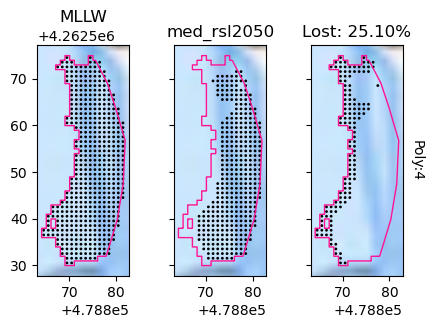

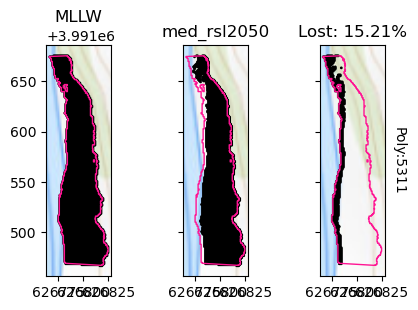

In [247]:
gdf_found['lost_beach'] = gdf_found['MLLW'] - gdf_found[scenp0]
for poly_ix, gdfi in gdf_found.groupby('poly_ix'):
    pct_lost = 100*gdfi['lost_beach'].mean() # before nan
    gdfi = gdfi.where(gdfi != 0, np.nan)
    fig, axes = plt.subplots(figsize=(5, 3), ncols=3, sharey=True)
    for ax, col in zip(axes, f'MLLW {scen} lost_beach'.split()):
        gdfi.plot(ax=ax, column=col, cmap='binary_r', markersize=1)
        gdf_beach_coned.loc[[poly_ix]].plot(ax=ax, **sty_cari)
        cx.add_basemap(ax=ax, crs=gdf_beach_coned.crs, source=cxbasemap_t, attribution=False, zoom=16)
        ax.set_title(col)
    ax.yaxis.set_label_position('right')
    ax.set_ylabel(f'Poly:{poly_ix}', rotation=270, labelpad=15)
    ax.set_title(f'Lost: {pct_lost:.2f}%')

## Check out duplicate polygons
- Some shared indices since polygons overlap some DEM tiles
- Requires the long loading in 'Check Against Final Results'

In [260]:
dct_tile_polys = {}
for tile, df in df_test.groupby('tile'):
    dct_tile_polys[tile] = df.poly_ix.unique()

In [261]:
lst_dupes = []
for k in dct_tile_polys.keys():
    polyids = dct_tile_polys[k]
    for k1, vs in dct_tile_polys.items():
        if k1 == k:
            continue
        for polyid in polyids:
            if polyid in vs and not polyid in lst_dupes:
                lst_dupes.append(polyid)
        
print (f'{len(lst_dupes)} duplicate polygon ids.')
df_dupes = df_test[df_test.poly_ix.isin(lst_dupes)]

22 duplicate polygon ids.


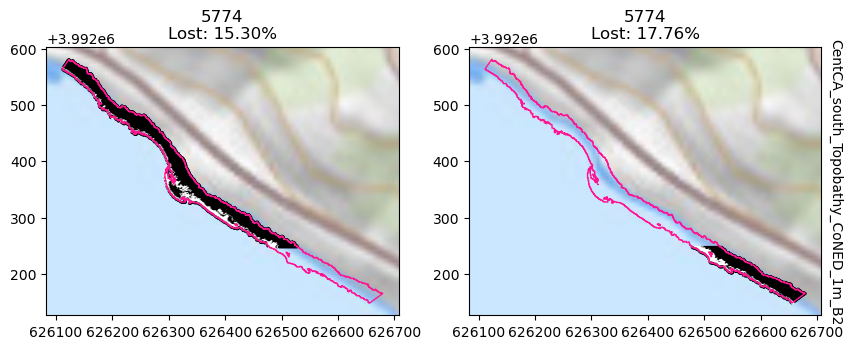

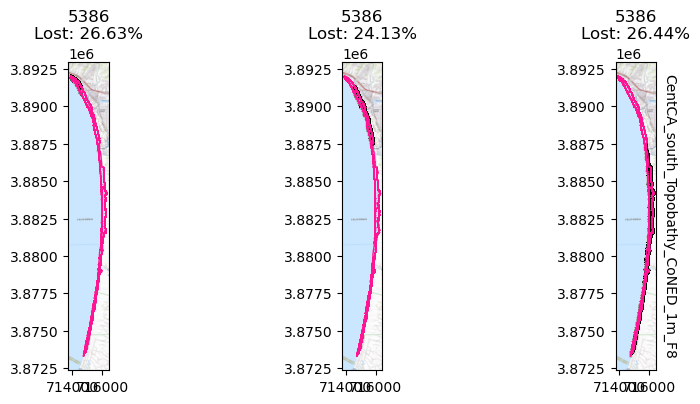

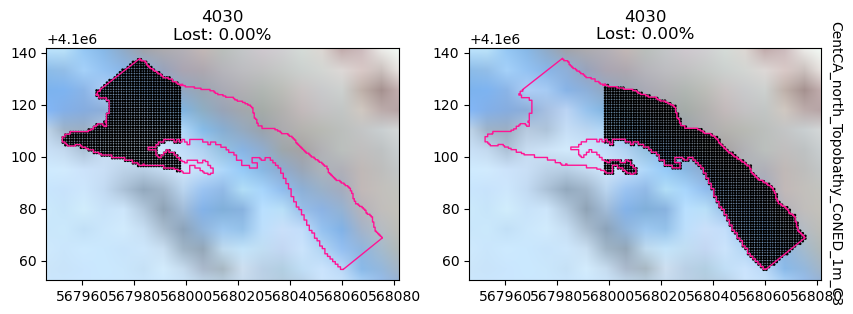

In [313]:
## show where there are overlaps; 
# won't matter later since we're getting all points and then calculating percentage

# take a random 3 poly dupes to plot
n = 3
np.random.seed(15)
polys_to_plot = np.random.choice(df_dupes.poly_ix.unique(), size=n, replace=False)
df_dupes_group = df_dupes.groupby('poly_ix')
for poly_ixi in polys_to_plot:
    df = df_dupes_group.get_group(poly_ixi)
    tile_uniq = df.tile.unique()
    cari_poly = gdf_beach_coned.loc[[poly_ixi]]
    
    fig, axes = plt.subplots(figsize=(10,4), ncols=len(tile_uniq))
    for j, tu in enumerate(tile_uniq):
        gdf_tile = gpd.read_file(BObj.path_ca_dems / f'{tu}_beach{s2_ext}.GeoJSON')
        gdf_tile_poly = gdf_tile[gdf_tile.poly_ix == poly_ixi].copy()
        
        # if this is 1, then we lost it (1-0)
        gdf_tile_poly['lost'] = gdf_tile_poly['MLLW'] - gdf_tile_poly[scen]
        pct_lost = 100 * gdf_tile_poly['lost'].mean()
        
        gdf_tile_poly.plot(ax=axes[j], column='lost', cmap='binary_r', markersize=1)
        cari_poly.plot(ax=axes[j], **sty_cari)
        cx.add_basemap(ax=axes[j], crs=gdf_beach_coned.crs, source=cxbasemap_t, attribution=False, zoom=14)
        axes[j].set_title(f'{poly_ixi}\nLost: {pct_lost:.2f}%')
    axes[j].set_ylabel(tu, rotation=270, labelpad=15)
    axes[j].yaxis.set_label_position('right');

# Check logs
- this won't work anymore since i changed the logs

## DEM tiles with no beach polygons
Looks okay. Some are very close but nothing to do I think.

In [248]:
# get the tile paths with no beach polygons
lst_res = []
with open(path_wd / f'log_{region}_pct.txt') as fh:
    for line in fh:
        if 'No beach polygons' in line:
            lp = line.strip().split(' ')
            lst_res.append(path_ca_dems / f'{lp[-1]}.tif')
            
print (f'Found {len(lst_res)} {region} CoNED tiles without any data in beach polygons')

Found 17 Central CoNED tiles without any data in beach polygons


In [ ]:
# this is the overview; can't see too much
print (f'{region} DEM tiles with no beach polygons')
lst_gsers  = []  # for total bounds
fig, axes  = plt.subplots(figsize=(10, 10))
for path in lst_res:
    da     = xrr.open_rasterio(path)
    gser_bounds_i = gpd.GeoSeries(box(*da.rio.bounds()), crs=da.rio.crs)
    gser_bounds_i.plot(ax=axes, **sty_coned)
    lst_gsers.append(gser_bounds_i)
    
wi, si, ei, ni = pd.concat(lst_gsers).total_bounds
gdf_beach_i = gdf_beach_coned.cx[wi:ei, si:ni]
gdf_beach_i.plot(ax=axes, **sty_cari)
axes.legend(handles=[rect_beach, rect_coned], loc='lower left')
cx.add_basemap(ax=axes, crs=gdf_beach_i.crs, source=cxbasemap, attribution=False)#, zoom=14)

Close ups of tiles with no polygons


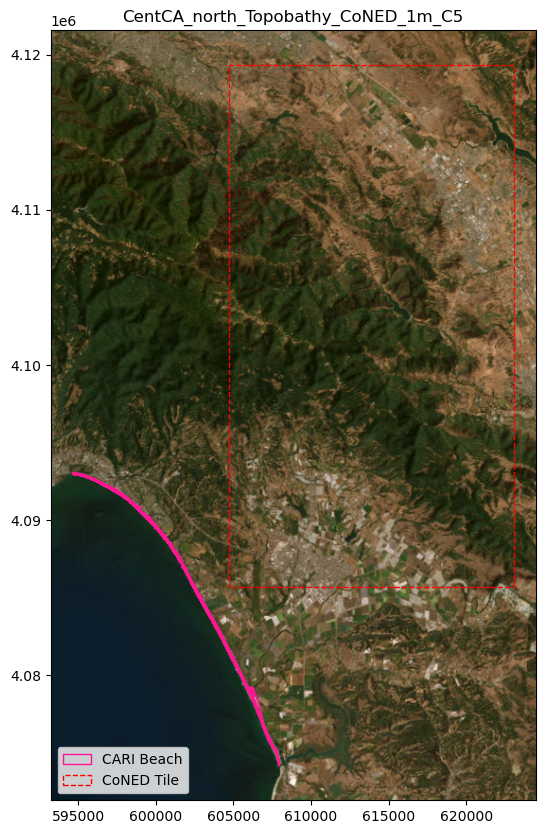

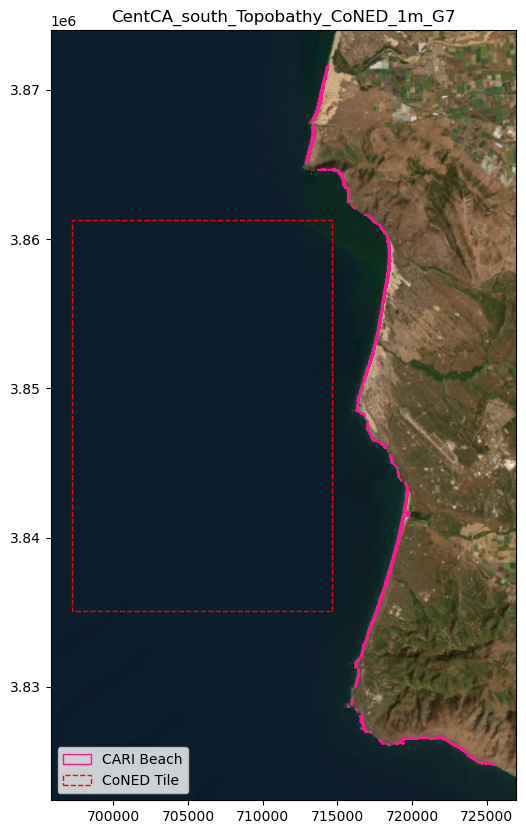

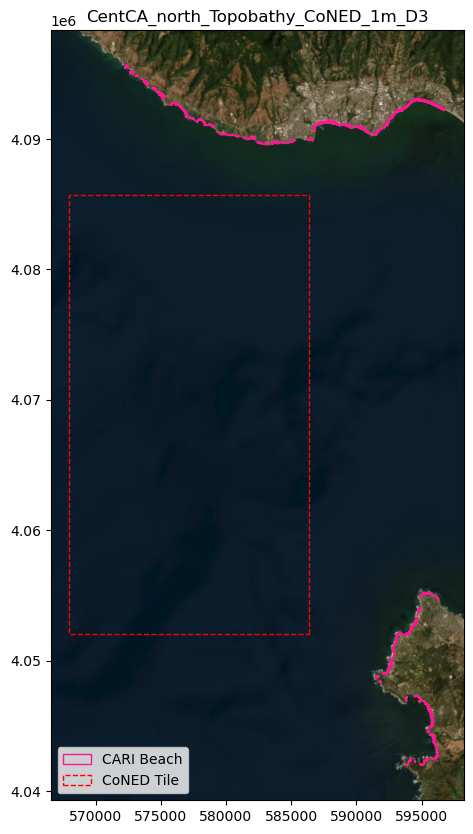

In [259]:
print ('Close ups of tiles with no polygons')
n = 3 # there are a lot; dont plot all of them
buff  = 1e4
for i, path in enumerate(lst_res):
    fig, axes  = plt.subplots(figsize=(10, 10))
    da         = xrr.open_rasterio(path)
    wi, si, ei, ni = da.rio.bounds()
    gser_bounds_i  = gpd.GeoSeries(box(wi, si, ei, ni), crs=da.rio.crs)
    
    # buffer to see if you find some
    gdf_beach_i    = gdf_beach_coned.cx[wi-buff:ei+buff, si-buff:ni+buff]

    gser_bounds_i.plot(ax=axes, **sty_coned)
    gdf_beach_i.plot(ax=axes, **sty_cari)
    
    axes.legend(handles=[rect_beach, rect_coned], loc='lower left')
    axes.set_title(path.stem)
    cx.add_basemap(ax=axes, crs=gdf_beach_i.crs, source=cxbasemap, attribution=False)

    if i == n-1:
        break

In [250]:
## double check there are no beach polygons after clipping them to the CoNED extent
failed = 0
for i, path in enumerate(lst_res):
    da             = xrr.open_rasterio(path)
    wi, si, ei, ni = da.rio.bounds()
    gdf_beach_i    = gdf_beach_coned.cx[wi:ei, si:ni]
    if not gdf_beach_i.empty:
        print ('This should be empty...')
        failed += 1
print (f'Number of weirdly failed: {failed} (should be 0)')

Number of weirdly failed: 0 (should be 0)


## Polygons with no lost beaches

In [ ]:
# get the tile paths with no beach polygons
lst_res = []
with open(path_wd / f'log_{region}_pct.txt') as fh:
    for line in fh:
        if 'Lost: 0' in line:
            lp = line.strip().split(' ')
            poly_ix = lp[2][2:-1]
            lst_res.append((path_ca_dems / f'{lp[0][:-1]}.tif', poly_ix))
            
# print (f'{len(lst_res)} {region} CoNED tiles without any data in beach polygons')
df_res = pd.DataFrame(lst_res, columns='path poly_ix'.split())
print (f'{len(df_res.groupby("path"))} CoNED tiles have polygons with no loss of beach')

In [ ]:
for i, (path_coned, dfi) in enumerate(df_res.groupby('path')):
    # plot the first few DEMs
    
    # if i < 10:
    #     continue
    
    if i > 10:
        break
        
    dai = xrr.open_rasterio(path_coned)
    gser_bounds_i = gpd.GeoSeries(box(*dai.rio.bounds()), crs=dai.rio.crs)
    gdf_ix        = gdf_beach_coned.loc[dfi['poly_ix'].to_numpy().astype(int)]

    fig, axes  = plt.subplots(figsize=(10, 10))
    gser_bounds_i.plot(ax=axes, **sty_coned)
    gdf_ix.plot(ax=axes, **sty_cari)
    
    axes.legend(handles=[rect_beach, rect_coned], loc='lower left')
    cx.add_basemap(ax=axes, crs=gdf_ix.crs, source=cxbasemap, attribution=False, zoom=14)
    

# Compare Polygons
- Check the new polygons (slivers removed) vs the old
- they're pretty close

In [15]:
gdf_beach0 = BObj.get_cari('beach')
gdf_beach1 = BObj.get_cari('beach', new=True)

In [16]:
gdf_m = gdf_beach0.sjoin(gdf_beach1, how='inner', predicate='intersects')
gdf_beach0.shape, gdf_beach1.shape, gdf_m.shape

((7084, 27), (4348, 17), (10506, 44))

In [24]:
gdf_beach0_poly = gdf_beach0.loc[[poly_ix_test]] # get the polygon run in test run above
gdf_beach1_close = gdf_beach1[gdf_beach1.intersects(poly_test)] # this exact index doesn't exist, getting the one close to it

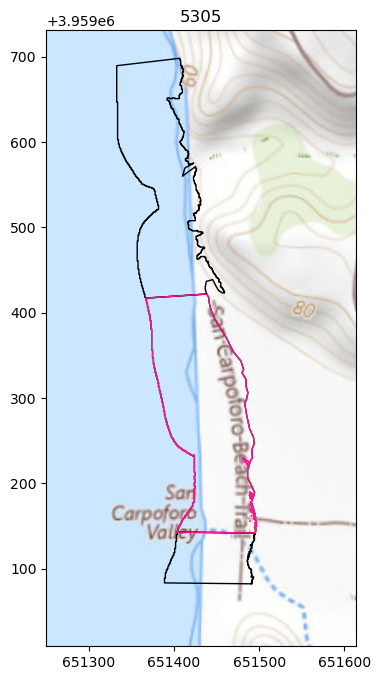

In [29]:
fig, axes = plt.subplots(figsize=(8, 8))
gdf_beach0_poly.buffer(100).plot(ax=axes, alpha=0) # make the plot bigger
gdf_beach1_close.plot(ax=axes, facecolor='none', edgecolor='black')
gdf_beach0_poly.plot(ax=axes, **sty_cari)
cx.add_basemap(ax=axes, crs=gdf_beach0.crs, source=cxbasemap_t, attribution=False, zoom=16)
axes.set_title(f'{poly_ix_test}');